## Commmunity Detection on Trip Advisor Reviews

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.6/991.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:

!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch

In [ ]:
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [ ]:
import os.path as osp
import sys

from sklearn.cluster import HDBSCAN

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

In [ ]:
def get_edges(nodes):
    edges = []
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            edges.append((nodes[i], nodes[j]))
    return edges

### Exploring Trip Advisor reviews hotels dataset

In [ ]:
# load dataset

df_reviews = pd.read_csv("https://raw.githubusercontent.com/win7/WebMining_TripAdvisor/main/data/tripadvisor_hoteles_cusco.csv")
df_reviews.head()

,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion,f7_fecHosped,f8_page
0,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Wayne S,Neat little place in the center of Cusco.,Nice boutique hotel. Staff were very friendly ...,50,October 2023,1.0
1,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Leslie W,Perfect hotel and experience,My husband and I stayed here for two nights wh...,50,September 2023,1.0
2,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Mimi,Amazing stay at Cusco,We had a pleasant stay at this hotel for 3 nig...,50,September 2023,1.0
3,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",T0niaYVR,Amazing service and hospitality received,From the start of my stay to the end of it I f...,50,August 2023,1.0
4,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Natacha Talbot,Breathtaking place and walkable to everything,"If you come to Cusco, this is the place to sta...",50,July 2023,1.0


In [ ]:
df_reviews.iloc[:, :6]

,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion
0,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Wayne S,Neat little place in the center of Cusco.,Nice boutique hotel. Staff were very friendly ...,50
1,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Leslie W,Perfect hotel and experience,My husband and I stayed here for two nights wh...,50
2,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Mimi,Amazing stay at Cusco,We had a pleasant stay at this hotel for 3 nig...,50
3,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",T0niaYVR,Amazing service and hospitality received,From the start of my stay to the end of it I f...,50
4,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Natacha Talbot,Breathtaking place and walkable to everything,"If you come to Cusco, this is the place to sta...",50
...,...,...,...,...,...,...
41481,Hanaq Wasi,NaN,Aalonsor,Cerrado,El hotel no había recibido la reserva por que ...,20
41482,Santa Ana Departamentos,NaN,chengtse,空間寬敞+親切的屋主,我們在造訪馬丘比丘前後共在此公寓住了三個晚上，其中很感謝屋主讓我們將主要的行李留在此地，方便...,50
41483,Tunky Wasi - Sapan Sachayoc,NaN,Nancy C,Excellent,Atendido por sus propietarios te hacen sentir ...,50
41484,Hospedaje Casa de Pajaros,NaN,Ori,Very friendly and welcoming,Came in through a friend's recommendation and ...,50


In [ ]:
# select columns to analysis

df_reviews = df_reviews[["f1_hotel", "f3_cliente", "f6_calificacion"]]
df_reviews

,f1_hotel,f3_cliente,f6_calificacion
0,Casa Cartagena Boutique Hotel & Spa,Wayne S,50
1,Casa Cartagena Boutique Hotel & Spa,Leslie W,50
2,Casa Cartagena Boutique Hotel & Spa,Mimi,50
3,Casa Cartagena Boutique Hotel & Spa,T0niaYVR,50
4,Casa Cartagena Boutique Hotel & Spa,Natacha Talbot,50
...,...,...,...
41481,Hanaq Wasi,Aalonsor,20
41482,Santa Ana Departamentos,chengtse,50
41483,Tunky Wasi - Sapan Sachayoc,Nancy C,50
41484,Hospedaje Casa de Pajaros,Ori,50


In [ ]:
# check NaN values

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41486 entries, 0 to 41485
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   f1_hotel         41486 non-null  object
 1   f3_cliente       41459 non-null  object
 2   f6_calificacion  41486 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 972.5+ KB


### Create graph

In [ ]:
# rating distribution

df_temp = df_reviews["f6_calificacion"].value_counts().to_frame()

x = df_temp.index
y = df_temp["f6_calificacion"].to_list()

fig = go.Figure(data=[go.Bar(
            x=x,
            y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(
    title='Distribution',
    title_x=0.5,
    xaxis_tickfont_size=14,
    xaxis=dict(
        title='Rating',
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title='Count',
        titlefont_size=16,
        tickfont_size=14,
    ),
    height=600, width=600
)
fig.show()

In [ ]:
df_reviews

,f1_hotel,f3_cliente,f6_calificacion
0,Casa Cartagena Boutique Hotel & Spa,Wayne S,50
1,Casa Cartagena Boutique Hotel & Spa,Leslie W,50
2,Casa Cartagena Boutique Hotel & Spa,Mimi,50
3,Casa Cartagena Boutique Hotel & Spa,T0niaYVR,50
4,Casa Cartagena Boutique Hotel & Spa,Natacha Talbot,50
...,...,...,...
41481,Hanaq Wasi,Aalonsor,20
41482,Santa Ana Departamentos,chengtse,50
41483,Tunky Wasi - Sapan Sachayoc,Nancy C,50
41484,Hospedaje Casa de Pajaros,Ori,50


In [ ]:
# user with two or more comments

df_user = df_reviews["f3_cliente"].value_counts().to_frame()
df_user = df_user[df_user["f3_cliente"] > 1]
df_user

KeyError: 'f3_cliente'

In [ ]:
# filter by user with two or more comments

users = list(df_user.index)
df_reviews = df_reviews[df_reviews["f3_cliente"].isin(users)]
df_reviews

,f1_hotel,f3_cliente,f6_calificacion
6,Casa Cartagena Boutique Hotel & Spa,Elizabeth S,50
14,Andean South Inn,Derek E,50
16,Andean South Inn,Robert B,40
19,Andean South Inn,Spencer B,50
24,Okidoki Cusco Hostal,Jeffrey F,50
...,...,...,...
41465,Inkaspacha Hostal,Tom R,30
41471,Inkaspacha Hostal,Paul,10
41473,Hostal Lucerito,Fernando V,40
41483,Tunky Wasi - Sapan Sachayoc,Nancy C,50


In [ ]:
# build graph (split bipartite graph in simple homogeneous graph (hotel))

list_edges = []
df_group = df_reviews.groupby("f3_cliente")
for name_of_group, contents_of_group in df_group:
    # print(name_of_group)
    # print(contents_of_group)
    nodes = contents_of_group["f1_hotel"].to_list()
    edges = get_edges(nodes)
    list_edges += edges
list_edges

df_edges = pd.DataFrame(list_edges, columns=["source", "target"])
df_edges

,source,target
0,El Tuco Hostel,Yawarmaki Hostel
1,El Tuco Hostel,Munaycha Hospedaje
2,Yawarmaki Hostel,Munaycha Hospedaje
3,Dragonfly Hostels Cusco,Sungate Hostels Cusco
4,Chakana House,LOKI Cusco
...,...,...
11375,Ukukus Hostel Peru,Puriwasi Hostels Cusco
11376,LOKI Cusco,Wild Rover Cusco
11377,San Agustin El Dorado,San Agustin El Dorado
11378,San Agustin El Dorado,Terra Andina Colonial Mansion


In [ ]:
# join the entities (hotel) into a single list

hotels = np.unique(df_edges["source"].to_list() + df_edges["target"].to_list())
# print(len(hotels))
hotels

array(['8a Cusco Guest House', 'Alegrias Inn Hotel',
       "Alfredo's Palace Hostal", 'Alta Vista Cusco',
       'Amanecer En El Sol Hotel', 'Amaru Colonial', 'Amaru Hostal',
       'Amazon Hostal', 'America Hostel', 'Anahuarque Hotel Boutique',
       'Andean Comfort Inn', 'Andean Dreams Hotel', 'Andean Home',
       'Andean Soul Hostel', 'Andean South Inn',
       'Andean Wings Boutique Hotel', 'Anden Inca Hotel',
       'Andenes Pisac Lodging House',
       'Andenes by Mountain Lodges of Peru', 'Andenes del Sol',
       'Andina Inn Boutique', 'Ankawa Hotel Boutique',
       'Antares Mystic Hotel', 'Antarki Guest House', 'Antawasi Hotel',
       'Antis Hostel Cusco', "Antonio's Hostal",
       'Apart Hotel R House Cusco', 'Apartamentos Quewe',
       'Apartment Samana House', 'Apu Huascaran Hostal', 'Apu Majestic',
       'Apu Wasi', 'Aqua Hotel Cusco', 'Aranjuez Cusco Hotel',
       'Arcopata Apartamento', 'Arcopata Guest House',
       'Arcopunco Guest House', 'Asiriq Wasi', 'Ataw

In [ ]:
# map each entity (hotel) to an integer number

mapping_hotels_idx = dict(zip(hotels, range(len(hotels))))
mapping_idx_hotels = dict(zip(range(len(hotels)), hotels))

df_edges_mapping = df_edges.copy()
df_edges_mapping["source"] = df_edges_mapping["source"].map(mapping_hotels_idx)
df_edges_mapping["target"] = df_edges_mapping["target"].map(mapping_hotels_idx)
# df_edges_mapping.sort_values(by=["source", "target"], inplace=True)
df_edges_mapping

,source,target
0,170,739
1,170,533
2,739,533
3,151,651
4,118,471
...,...,...
11375,700,595
11376,471,732
11377,631,631
11378,631,664


In [ ]:
# graph details

G = nx.from_pandas_edgelist(df_edges_mapping, "source", "target")
print("Num. of nodes: \t{}".format(G.number_of_nodes()))
print("Num. of edges: \t{}".format(G.number_of_edges()))
print("Density: \t{}".format(nx.density(G)))

Num. of nodes: 	742
Num. of edges: 	7147
Density: 	0.02599750464695847


In [ ]:
degrees = {node:val for (node, val) in G.degree()}
degrees = dict(sorted(degrees.items(), key=lambda item: item[1], reverse=True))
degrees

{528: 271,
 471: 232,
 560: 212,
 156: 186,
 732: 172,
 159: 170,
 685: 166,
 15: 151,
 734: 148,
 554: 147,
 66: 146,
 139: 145,
 664: 137,
 6: 136,
 151: 129,
 164: 128,
 176: 125,
 18: 121,
 621: 120,
 394: 118,
 374: 115,
 370: 114,
 667: 111,
 155: 111,
 434: 110,
 656: 106,
 236: 103,
 684: 100,
 345: 98,
 553: 97,
 718: 90,
 702: 89,
 65: 88,
 170: 87,
 641: 86,
 632: 86,
 363: 84,
 64: 80,
 320: 80,
 392: 79,
 444: 78,
 630: 78,
 580: 77,
 690: 77,
 616: 75,
 44: 74,
 253: 74,
 577: 72,
 5: 72,
 631: 69,
 514: 69,
 677: 69,
 396: 68,
 692: 67,
 608: 67,
 30: 67,
 654: 66,
 607: 66,
 499: 63,
 484: 63,
 501: 63,
 731: 61,
 547: 61,
 497: 61,
 706: 60,
 335: 60,
 106: 59,
 595: 58,
 168: 58,
 22: 58,
 337: 58,
 358: 58,
 163: 57,
 142: 56,
 633: 56,
 681: 56,
 532: 55,
 516: 55,
 410: 53,
 468: 53,
 49: 52,
 425: 51,
 617: 51,
 624: 51,
 483: 51,
 384: 51,
 558: 50,
 262: 50,
 409: 49,
 82: 49,
 103: 49,
 578: 48,
 568: 47,
 102: 46,
 401: 46,
 74: 46,
 489: 46,
 700: 44,
 696: 4

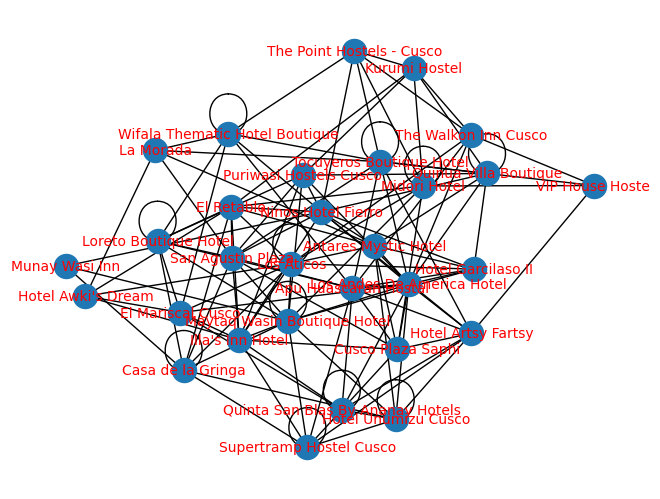

In [ ]:
nodes = list(degrees.keys())[50:80]

SG =  G.subgraph(nodes)
SG = nx.relabel_nodes(SG, mapping_idx_hotels)

pos = nx.random_layout(SG)
nx.draw(SG, with_labels=True, font_color="red", font_size=10)
plt.show()

In [ ]:
# convert list of edges to COO format (Torch Geometric)

hotel_ids1 = torch.LongTensor(df_edges_mapping["source"].to_list())
hotel_ids2 = torch.LongTensor(df_edges_mapping["target"].to_list())
edge_index = torch.stack((hotel_ids1, hotel_ids2))
edge_index

tensor([[170, 170, 739,  ..., 631, 631, 631],
        [739, 533, 533,  ..., 631, 664, 664]])

### Community detection

In [ ]:
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
# create model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    edge_index,
    embedding_dim=16,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=2.0,
    sparse=True,
).to(device)

num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [ ]:
# train model

for epoch in range(1, 301):
    loss = train(model, loader, optimizer, device)
    # acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch: 001, Loss: 2.1502
Epoch: 002, Loss: 1.9524
Epoch: 003, Loss: 1.7897
Epoch: 004, Loss: 1.6549
Epoch: 005, Loss: 1.5402
Epoch: 006, Loss: 1.4351
Epoch: 007, Loss: 1.3523
Epoch: 008, Loss: 1.2750
Epoch: 009, Loss: 1.2195
Epoch: 010, Loss: 1.1642
Epoch: 011, Loss: 1.1160
Epoch: 012, Loss: 1.0769
Epoch: 013, Loss: 1.0421
Epoch: 014, Loss: 1.0158
Epoch: 015, Loss: 0.9848
Epoch: 016, Loss: 0.9643
Epoch: 017, Loss: 0.9452
Epoch: 018, Loss: 0.9286
Epoch: 019, Loss: 0.9161
Epoch: 020, Loss: 0.8997
Epoch: 021, Loss: 0.8913
Epoch: 022, Loss: 0.8819
Epoch: 023, Loss: 0.8731
Epoch: 024, Loss: 0.8637
Epoch: 025, Loss: 0.8556
Epoch: 026, Loss: 0.8495
Epoch: 027, Loss: 0.8445
Epoch: 028, Loss: 0.8396
Epoch: 029, Loss: 0.8349
Epoch: 030, Loss: 0.8305
Epoch: 031, Loss: 0.8258
Epoch: 032, Loss: 0.8225
Epoch: 033, Loss: 0.8197
Epoch: 034, Loss: 0.8166
Epoch: 035, Loss: 0.8126
Epoch: 036, Loss: 0.8116
Epoch: 037, Loss: 0.8089
Epoch: 038, Loss: 0.8072
Epoch: 039, Loss: 0.8053
Epoch: 040, Loss: 0.8024


In [ ]:
# get node-embeddings

model.eval()
z = model().detach().cpu().numpy()
df_embeddings = pd.DataFrame(z)
df_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.597784,-0.193714,0.742298,0.285620,-0.168627,-0.131785,1.317532,0.406078,0.438944,-0.129097,-0.343725,0.682575,0.112616,0.449555,0.189431,0.316602
1,-0.189837,0.194033,0.779918,0.946302,0.927412,0.190242,-0.097079,-0.262174,0.086473,0.461165,-0.334178,-0.462805,-0.510147,0.590329,0.381269,0.370759
2,-0.143284,-0.155706,-0.139202,-0.150799,0.080357,-0.044106,-0.116942,0.114172,-0.025288,-0.021161,-0.103627,-0.122725,0.059695,-0.132842,-0.020643,0.174460
3,0.282271,0.247662,0.737100,-0.374786,0.346324,-0.625190,0.204313,-0.018566,0.618426,-0.723617,-0.617760,-0.155120,-0.073251,0.472338,-0.983243,0.373466
4,-0.133546,-0.068440,0.060908,0.017082,-0.091790,0.132700,-0.034935,0.116315,0.043351,0.062492,-0.200158,-0.151061,0.022303,-0.070897,0.047260,0.030423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,-0.020734,0.018529,0.171844,0.002476,0.091539,0.136841,-0.026576,-0.251195,-0.064901,0.077041,-0.151941,-0.054499,-0.221384,-0.000620,0.011102,0.075394
738,-0.073336,0.006064,-0.051901,-0.020672,-0.129537,0.013964,-0.075773,-0.030685,-0.022085,-0.017435,0.000293,-0.017758,0.036579,-0.065716,-0.049146,0.016334
739,0.013887,-0.013286,0.050569,0.196261,-0.159317,0.043440,-0.073626,0.113298,-0.038105,0.012844,0.119204,-0.193576,0.042777,-0.037867,-0.097244,0.036639
740,0.463457,0.105775,0.062753,0.196213,0.518308,-0.325884,0.810677,0.411844,-0.116408,-0.176180,0.240578,0.486240,0.051961,-1.375663,-0.270925,0.004052


In [ ]:
# dimensional reduction

z_2d = PCA(n_components=2).fit_transform(z)
df_embeddings_2d = pd.DataFrame(z_2d)
df_embeddings_2d

,0,1
0,-0.560385,0.204010
1,-0.502886,0.194516
2,0.171713,0.149950
3,-0.666001,0.082761
4,0.202680,0.109034
...,...,...
737,-0.042220,0.053552
738,0.124622,0.018585
739,0.125189,0.126442
740,-0.505278,0.031344


In [ ]:
# plot embeddings

fig = go.Figure(data=go.Scatter(x=df_embeddings_2d[0],
                                y=df_embeddings_2d[1],
                                mode='markers',
                                text=list(mapping_hotels_idx.keys())
                                ))

fig.update_layout(title='Node-embeddings', title_x=0.5, height=600, width=600)
fig.show()

In [ ]:
# clustering

df_embeddings_2d_clu = df_embeddings_2d.copy()
hdb = HDBSCAN(min_cluster_size=15, min_samples=5).fit(df_embeddings_2d_clu)
df_embeddings_2d_clu["labels"] = hdb.labels_
df_embeddings_2d_clu

,0,1,labels
0,-0.560385,0.204010,1
1,-0.502886,0.194516,1
2,0.171713,0.149950,2
3,-0.666001,0.082761,1
4,0.202680,0.109034,2
...,...,...,...
737,-0.042220,0.053552,2
738,0.124622,0.018585,2
739,0.125189,0.126442,2
740,-0.505278,0.031344,1


In [ ]:
# plot clusters
fig = go.Figure(data=go.Scatter(x=df_embeddings_2d_clu[0],
                                y=df_embeddings_2d_clu[1],
                                marker=dict(
                                    size=8,
                                    color=df_embeddings_2d_clu["labels"],
                                    colorscale="Viridis",
                                    opacity=0.9,
                                    line_width=0.5
                                ),
                                # showlegend=True,
                                text=list(mapping_hotels_idx.keys()),
                                mode="markers"))

fig.update_layout(title='Community detection: Node-embeddings', title_x=0.5, height=600, width=600)
fig.show()